### Прогноз модели ARIMA/VAR


Документация по статистическим моделям:
https://www.statsmodels.org/stable/index.html

In [36]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

## Data analysis

  observation_date  IPG3113N
0       1972-01-01   85.6945
1       1972-02-01   71.8200
2       1972-03-01   66.0229
3       1972-04-01   64.5645
4       1972-05-01   65.0100


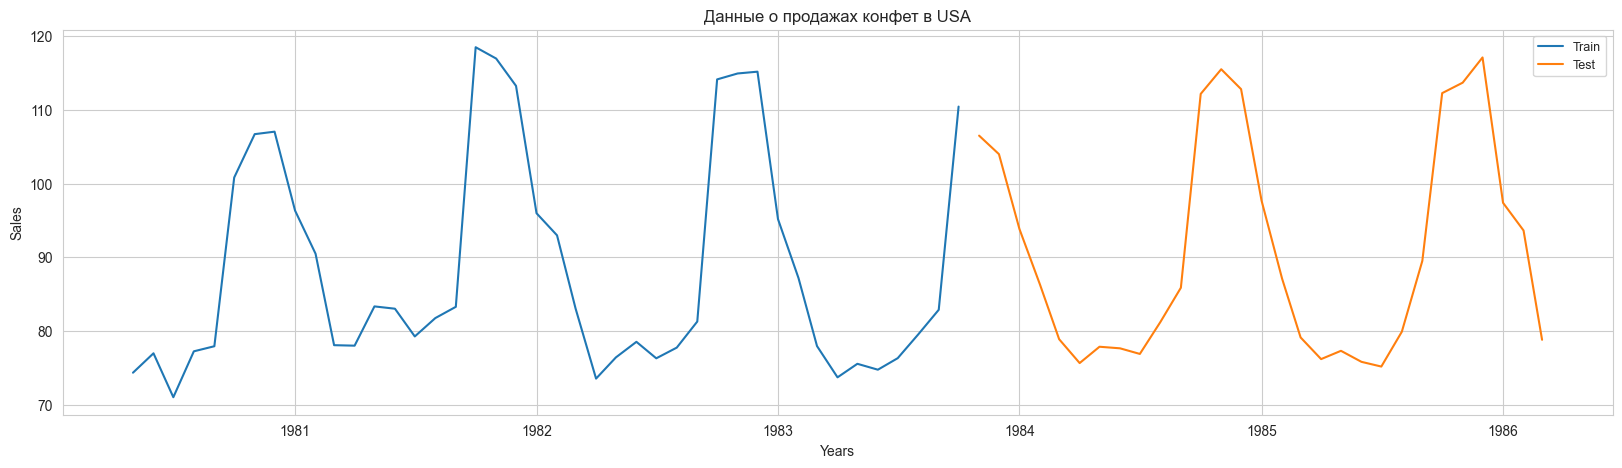

Выборка - train
Dickey-Fuller test: p=0.000008


<Figure size 2000x500 with 0 Axes>

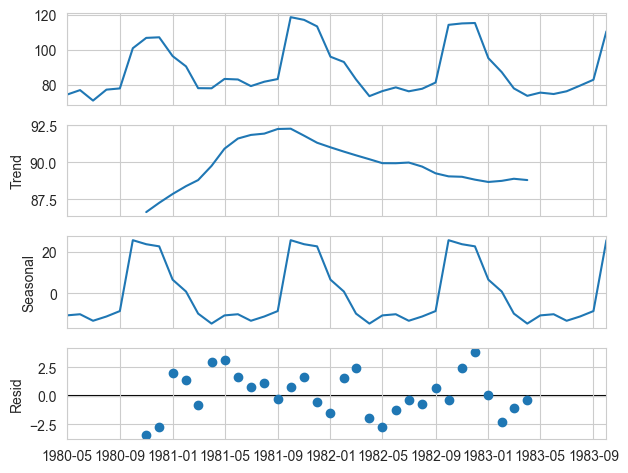

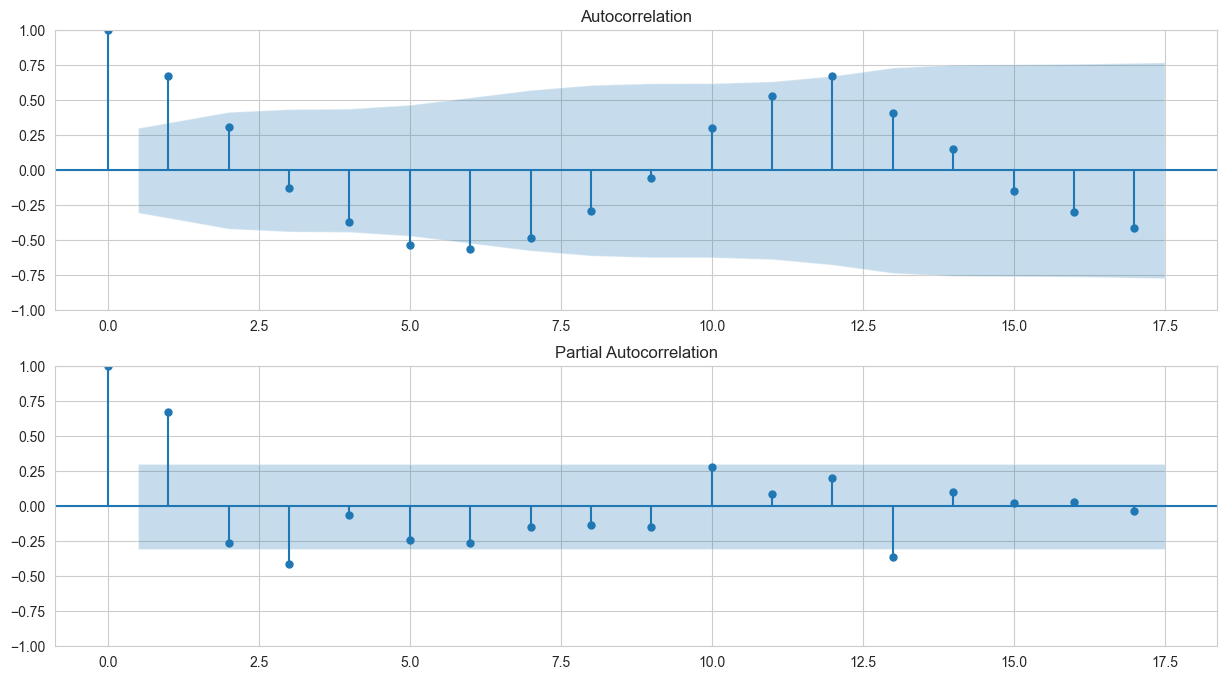

Выборка - test
Dickey-Fuller test: p=0.000325


<Figure size 2000x500 with 0 Axes>

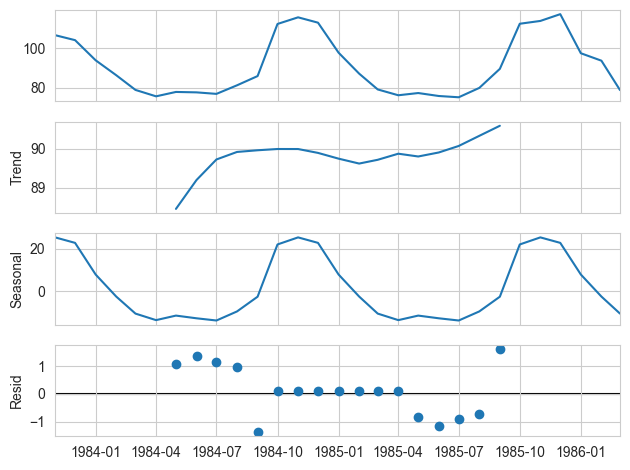

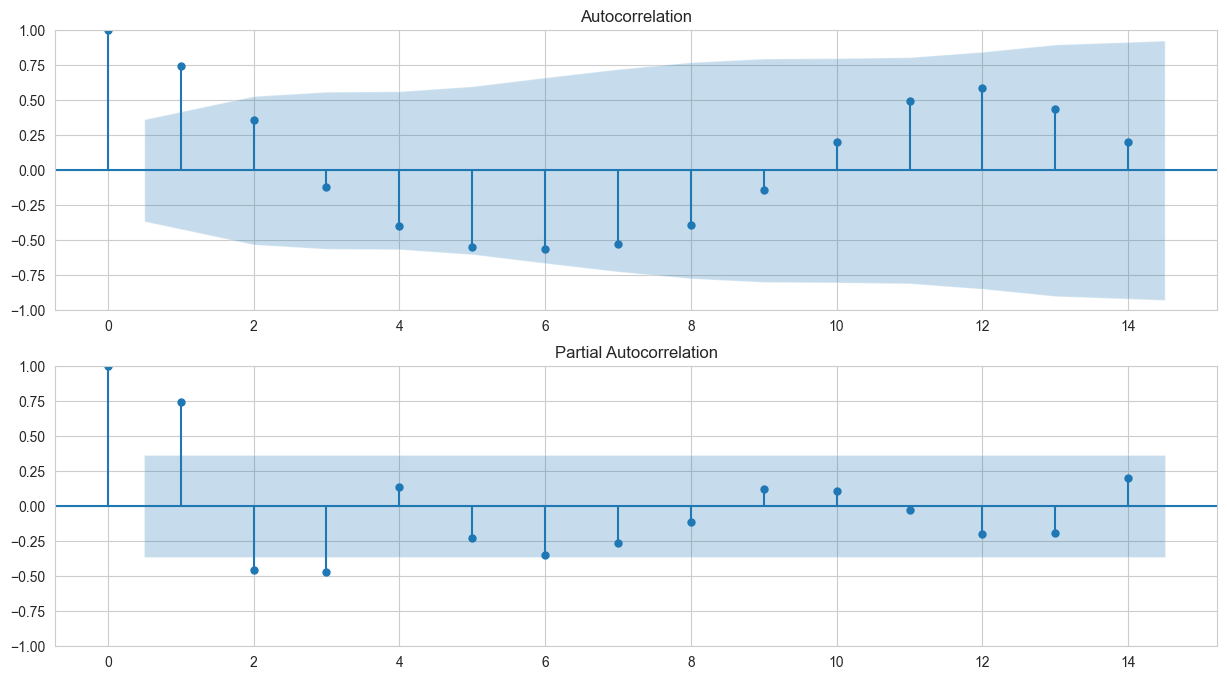

In [46]:
df = pd.read_csv('candy_production.csv', parse_dates=['observation_date'])
print(df.head(5))

# season_length = 12  # Длина сезона (12 месяцев) взял на основе анализа
# periods = 8  # Количество периодов в данных (~8 лет)

series = df.loc[100:170,['observation_date','IPG3113N']].set_index('observation_date')
# разделение данных на тренировочные и тестовые выборки (60% / 40%)
train_size = int(len(series) * 0.6)
train_series = series.iloc[:train_size,:]
test_series = series.iloc[train_size:,:]


# возьму данные ~8 лет
plt.figure(figsize=(20, 5))
plt.plot(train_series, label=f"Train")
plt.plot(test_series,label=f"Test")
plt.legend(loc='best',prop={'size': 9})
plt.ylabel("Sales")
plt.xlabel("Years")
plt.title('Данные о продажах конфет в USA')
plt.show()

# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

for set_name, ts in zip(['train', 'test'],[train_series, test_series]):
    print(f'Выборка - {set_name}')
    print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(ts.values)[1])

    plt.figure(figsize=(20, 5))
    sm.tsa.seasonal_decompose(ts).plot()
    plt.show()

    # let's calculate autocorrelation and partial autocorrelation components
    plt.figure(figsize=(15, 8))

    # autocorrelation
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(ts.values.squeeze(), ax=ax)

    # partial autocorrelation
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(ts.values.squeeze(), ax=ax)
    plt.show()

Number of analysed models: 32
          parameters         aic       rmse
23  (1, 0, 1, 1, 12)  270.930120   3.651047
21  (1, 0, 1, 0, 12)  271.124510   9.303033
31  (1, 1, 1, 1, 12)  272.842259   3.582037
29  (1, 1, 1, 0, 12)  273.104458   9.511570
19  (1, 0, 0, 1, 12)  304.298617  14.816812
          parameters         aic      rmse
7   (0, 0, 1, 1, 12)  330.638621  3.141400
31  (1, 1, 1, 1, 12)  272.842259  3.582037
5   (0, 0, 1, 0, 12)  334.736022  3.605568
23  (1, 0, 1, 1, 12)  270.930120  3.651047
13  (0, 1, 1, 0, 12)  306.371027  3.685419
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -131.421
Date:                            Fri, 20 Dec 2024   AIC                            272.842
Time:                                    17:47:37   BIC                            2

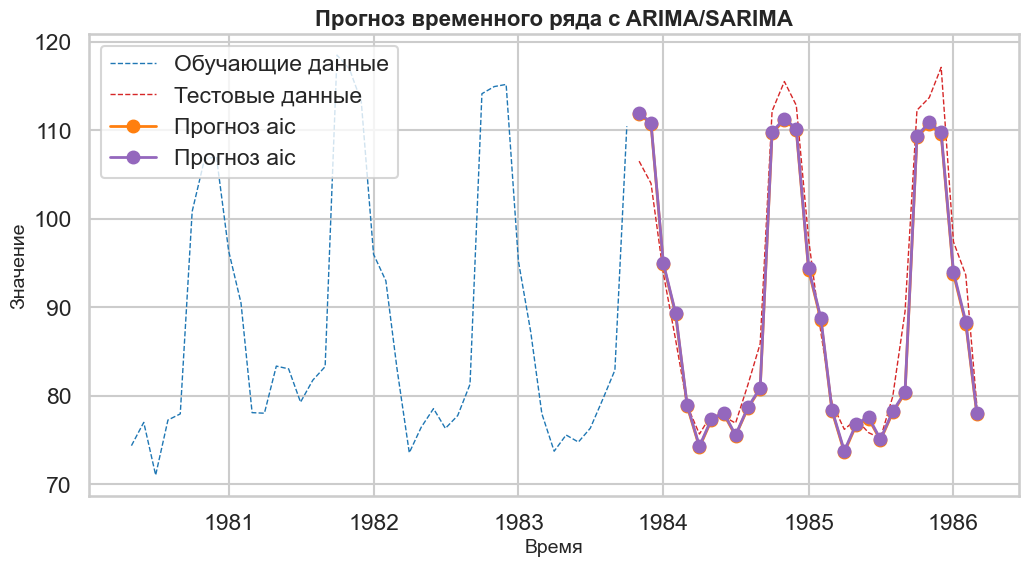

In [98]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

ps = range(0, 2) # AR компонент выбирается при отклонении от порогового значения (синяя область) на графике PACF. В данном случае видно, что значительные отклонения присутствуют только на 1 лаге и сезоном лаге = 12. Но можно добавить еще 1 для эксперимента, поэтому от 0 до 2
d  = 0 # потому что дифиренцирование с лагом 1 уже стационарный ряд и таким образом не сильно разрушаем зависимость в данных
qs = range(0, 2) # Аналогичная ситуация, как с AR, но смотрим на график ACF и видим, что ситуация схожа. Поэтому от 0 до 2
Ps = range(0, 2) # выбираем аналогично AR, но для меньшего числа переборов оставим от 0 до 1
D  = 0 
Qs = range(0, 2) # выбираем аналогично MA, но для меньшего числа переборов оставим от 0 до 1
order = [6,12]

parameters = product(ps, qs, Ps, Qs, order)
parameters_list = list(parameters)
print("Number of analysed models:", len(parameters_list))


# here we will choose the best model
results = []
best_aic = float("inf")
best_rmse = float("inf")

for param in parameters_list:
    
    # try except for the case of wrong parameters
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_series.values,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], param[4]),
        ).fit(disp=-1)

    # print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    preds = model.forecast(test_series.values.shape[0])
    rmse = root_mean_squared_error(test_series.values, preds)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model_aic = model
        best_aic = aic
        best_param_aic = param
        aic_forecast =  preds.copy()

    # save best model, aic, parameters
    if rmse < best_rmse:
        best_model_rmse = model
        best_rmse = aic
        best_param_rmse = param
        rmse_forecast =  preds.copy()


    results.append([param, model.aic, rmse])

# Top models aic
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic", "rmse"]
print(result_table.sort_values(by="aic", ascending=True).head())

# Top models rmse
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic", "rmse"]
print(result_table.sort_values(by="rmse", ascending=True).head())


print(best_model_rmse.summary(), best_model_aic.summary(), '\n\n')

# Визуализация результатов
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 6))


print(f"RMSE (aic критерий) на тестовых данных: {result_table.sort_values(by='aic', ascending=True).iloc[0,-1]:.2f}")
print(f"RMSE (rmse критерий) на тестовых данных: {result_table.sort_values(by='rmse', ascending=True).iloc[0,-1]:.2f}")

# График обучающих данных
plt.plot(train_series, label="Обучающие данные", color="tab:blue", linestyle="--", linewidth=1)

# График тестовых данных
plt.plot(test_series, label="Тестовые данные", color="tab:red", linestyle="--", linewidth=1)

# График прогнозов на тестовых данных
plt.plot(test_series.index, aic_forecast, label="Прогноз aic", color="tab:orange", marker="o", linewidth=2)

# График прогнозов на тестовых данных
plt.plot(test_series.index, rmse_forecast, label="Прогноз aic", color="tab:purple", marker="o", linewidth=2)

# Настройка графика
plt.title("Прогноз временного ряда c ARIMA/SARIMA", fontsize=16, weight="bold")
plt.xlabel("Время", fontsize=14)
plt.ylabel("Значение", fontsize=14)
plt.legend()
plt.show()